In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


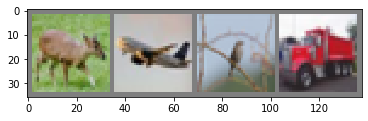

 deer plane  bird truck


In [3]:
# 画像を表示する関数
def imshow(img):
    img = img / 2 + 0.5     # 正規化を解除
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# トレーニング画像をランダムに取得する
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像表示
imshow(torchvision.utils.make_grid(images))
# ラベル表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# 転移学習
net = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [10]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
num_features = net.classifier[6].in_features
print(num_features)  # 4096

# 最終層を書き換える
net.classifier[6] = nn.Linear(in_features=num_features, out_features=10)
print(net)

4096
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
net = net.to(device)

In [25]:
for epoch in range(2):  # データセットを複数回ループする

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 入力を取得。データは[入力、ラベル]のリスト
        inputs, labels = data

        # パラメータの勾配の最適化
        optimizer.zero_grad()

        # テンソルをGPUに移動
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 結果表示
        running_loss += loss.item()
        if i % 2000 == 1999:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


[1,  2000] loss: 1.363
[1,  4000] loss: 1.015
[1,  6000] loss: 0.860
[1,  8000] loss: 0.789
[1, 10000] loss: 0.730
[1, 12000] loss: 0.685
[2,  2000] loss: 0.551
[2,  4000] loss: 0.533
[2,  6000] loss: 0.512
[2,  8000] loss: 0.530
[2, 10000] loss: 0.514
[2, 12000] loss: 0.500


In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [34]:
device

device(type='cuda')

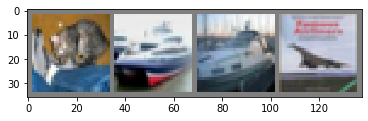

GroundTruth:    cat  ship  ship plane


In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像の結果を表示する
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [29]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
images = images.to(device)
labels = labels.to(device)

In [0]:
outputs = net(images)

In [38]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [40]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 82 %


In [42]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82 %
Accuracy of   car : 88 %
Accuracy of  bird : 64 %
Accuracy of   cat : 76 %
Accuracy of  deer : 78 %
Accuracy of   dog : 83 %
Accuracy of  frog : 89 %
Accuracy of horse : 79 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %
